In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import pandas as pd
import os
project_folder_path = '/content/drive/MyDrive/Kool/sissejuhatus_andmeteadusesse/projekt/Project_C4'
df_train = pd.read_csv(os.path.join(project_folder_path, "df_train.csv"))
df_test = pd.read_csv(os.path.join(project_folder_path, "df_test.csv"))

In [ ]:
season_map = {
    "Winter": 0,
    "Spring": 1,
    "Summer": 2,
    "Fall":   3
}

df_train['season'] = df_train['season'].map(season_map)
df_test['season']  = df_test['season'].map(season_map)

In [ ]:
df_train.head()

,date,trips,median_duration,tavg,prcp,wspd,day_name,day_of_week,is_weekend,season
0,2013-06-01,8691,867,28.1,0.0,17.1,Saturday,5,1,1
1,2013-06-02,15942,813,27.8,0.0,21.1,Sunday,6,1,1
2,2013-06-03,7585,692,23.6,44.6,13.2,Monday,0,0,1
3,2013-06-04,15692,832,20.2,0.0,19.5,Tuesday,1,0,1
4,2013-06-05,15632,797,19.0,0.0,14.2,Wednesday,2,0,1


In [ ]:
df_test.head()

,date,trips,median_duration,tavg,prcp,wspd,day_name,day_of_week,is_weekend,season
0,2020-01-01,18160,542,4.4,0.0,17.9,Wednesday,2,0,0
1,2020-01-02,41614,551,3.7,0.9,12.6,Thursday,3,0,0
2,2020-01-03,31920,522,7.5,3.0,8.8,Friday,4,0,0
3,2020-01-04,29480,526,8.2,4.5,6.5,Saturday,5,1,0
4,2020-01-05,27636,500,5.7,0.3,7.4,Sunday,6,1,0


In [ ]:
df = pd.concat([df_train, df_test], ignore_index=True)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

split_date = "2023-01-01"

# Features

In [ ]:
import numpy as np

# Basic time components
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['day_of_year'] = df['date'].dt.dayofyear

# Fourier - weekly
df['sin_week'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['cos_week'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# Fourier - yearly
df['sin_year'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['cos_year'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

# Trend
df['trend'] = np.arange(len(df))

# Weather interactions
df['temp_x_weekend'] = df['tavg'] * df['is_weekend']
df['rain_x_season'] = df['prcp'] * df['season']
df['wind_x_season'] = df['wspd'] * df['season']
df['temp_x_season'] = df['tavg'] * df['season']
df['month_x_temp'] = df['month'] * df['tavg']

# Weather polynomial
df['tavg2'] = df['tavg']**2
df['prcp2'] = df['prcp']**2
df['wspd2'] = df['wspd']**2

# Lags
df['lag_1'] = df['trips'].shift(1)
df['lag_7'] = df['trips'].shift(7)
df['lag_14'] = df['trips'].shift(14)
df['lag_30'] = df['trips'].shift(30)

# Rolling Means
df['rolling_7'] = df['trips'].rolling(7).mean()
df['rolling_14'] = df['trips'].rolling(14).mean()
df['rolling_30'] = df['trips'].rolling(30).mean()

# Rolling STD
df['rolling_std_7'] = df['trips'].rolling(7).std()
df['rolling_std_14'] = df['trips'].rolling(14).std()
df['rolling_std_30'] = df['trips'].rolling(30).std()

df = df.dropna().reset_index(drop=True)

df_train_new = df[df['date'] < split_date].reset_index(drop=True)
df_test_new  = df[df['date'] >= split_date].reset_index(drop=True)

df_train = df_train_new.copy()
df_test = df_test_new.copy()

features = [
    'median_duration',
    'tavg','tavg2',
    'prcp','prcp2',
    'wspd','wspd2',
    'day_of_week','is_weekend','season',
    'trend','sin_year','cos_year','sin_week','cos_week',
    'temp_x_weekend','rain_x_season','wind_x_season','temp_x_season','month_x_temp',
    'lag_1','lag_7','lag_14','lag_30',
    'rolling_7','rolling_14','rolling_30',
    'rolling_std_7','rolling_std_14','rolling_std_30'
]

X_train = df_train[features]
X_test = df_test[features]

y_train = df_train['trips']
y_test = df_test['trips']


# Random Forest Regression

RF is built to learn short-term nonlinear dependence.

RF is excellent at local patterns,
Linear Regression is excellent at long-term seasonal patterns.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Train the model
rf_model = RandomForestRegressor(
    n_estimators=600,
    max_depth=30,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features=0.7,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

rf_model.fit(X_train, y_train)

# Predict
rf_preds = rf_model.predict(X_test)

# Evaluate
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_r2 = r2_score(y_test, rf_preds)

print(f"Random Forest MAE: {rf_mae:.2f}")
print(f"Random Forest RMSE: {rf_rmse:.2f}")
print(f"Random Forest R2: {rf_r2:.2f}")

Random Forest MAE: 12650.48
Random Forest RMSE: 15817.57
Random Forest R2: 0.76


In [ ]:
import pandas as pd

# Tunnuste tähtsus
feature_importances = pd.Series(rf_model.feature_importances_, index=features)

print("Top 25 Feature Importances:")
print(feature_importances.nlargest(25))


Top 25 Feature Importances:
rolling_7          0.602418
rolling_14         0.187632
rolling_30         0.050775
lag_1              0.028139
median_duration    0.025242
prcp               0.010701
prcp2              0.010570
rolling_std_7      0.010255
rain_x_season      0.009306
lag_7              0.008181
lag_14             0.006497
day_of_week        0.004531
trend              0.004497
rolling_std_14     0.004490
sin_week           0.004135
lag_30             0.003180
tavg               0.002937
rolling_std_30     0.002678
cos_year           0.002582
month_x_temp       0.002502
is_weekend         0.002486
tavg2              0.002324
temp_x_weekend     0.002237
wind_x_season      0.002127
wspd               0.002020
dtype: float64


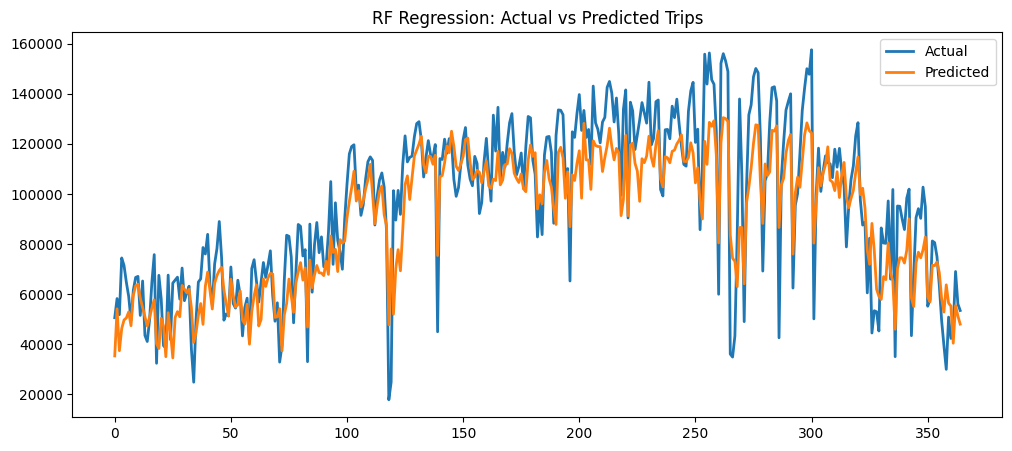

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test.values, label='Actual', linewidth=2)
plt.plot(rf_preds, label='Predicted', linewidth=2)
plt.title("RF Regression: Actual vs Predicted Trips")
plt.legend()
plt.show()

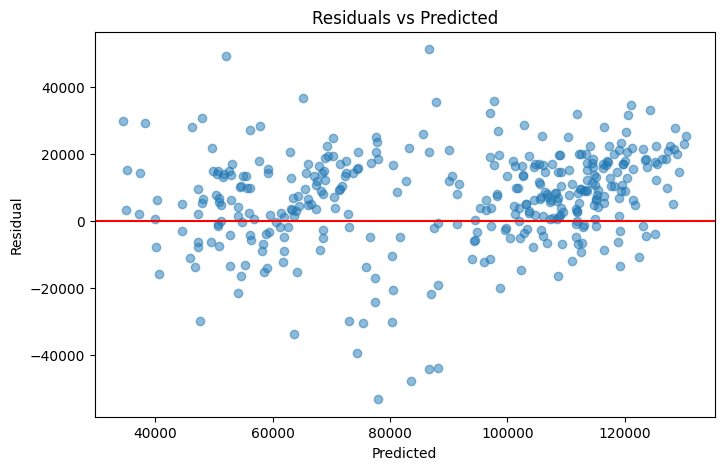

In [ ]:
# Residuals vs Predicted
residuals = y_test.values - rf_preds
plt.figure(figsize=(8,5))
plt.scatter(rf_preds, residuals, alpha=0.5)
plt.axhline(0, color='red')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.show()

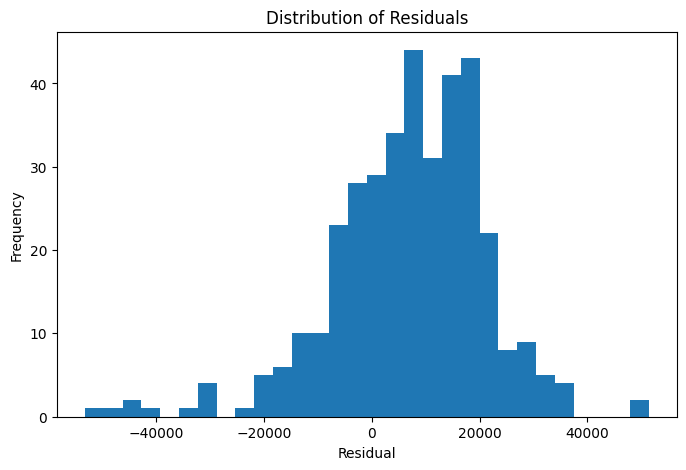

In [ ]:
# Distribution of Residuals
plt.figure(figsize=(8,5))
plt.hist(residuals, bins=30)
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()